In [1]:
import json
import pandas as pd
import time
import copy
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
import matplotlib.patches as mpatches

In [2]:

start = time.time()
business = []
with open('business.json','r') as f:
    for lines in f:
        business.append(json.loads(lines))
R = []  ### R[] stores the 5899 restaurants info 
for row in business:
    if row['city'] == 'Las Vegas' and 'Restaurants' in row['categories']:
        R.append([row['business_id'], row['latitude'],row['longitude']])
print(len(R))
print(R[0])
end = time.time()
print("total time", end - start)

5899
['Pd52CjgyEU3Rb8co6QfTPw', 36.0669136, -115.1708484]
total time 5.5084547996521


In [3]:
ID_R = set(i[0] for i in R)
print(len(ID_R))

review = []
with open('review.json','r') as f:
    for lines in f:
        review.append(json.loads(lines))
print(review[0])

5899
{'review_id': 'v0i_UHJMo_hPBq9bxWvW4w', 'user_id': 'bv2nCi5Qv5vroFiqKGopiw', 'business_id': '0W4lkclzZThpx3V65bVgig', 'stars': 5, 'date': '2016-05-28', 'text': "Love the staff, love the meat, love the place. Prepare for a long line around lunch or dinner hours. \n\nThey ask you how you want you meat, lean or something maybe, I can't remember. Just say you don't want it too fatty. \n\nGet a half sour pickle and a hot pepper. Hand cut french fries too.", 'useful': 0, 'funny': 0, 'cool': 0}


In [6]:
rev_d = {}
for row in review:
    bid = row['business_id']
    if bid in ID_R:
        if bid in rev_d:
            rev_d[bid].append(row['text'])
        else:
            rev_d[bid] = [row['text']]

In [7]:
RR = copy.deepcopy(R)
for i in RR:
    b = rev_d[i[0]]
    i.append(b)
print(RR[0][3][0])

Nice, open bar with great views of the strip and golf course.  Patio seating also.  Nice happy hour prices.  Had the carnitas nachos...very good.  And they serve breakfast all day.  Not noisy or smoky


In [11]:
X_vec = [] ### all business with all reviews
for i in RR:
    X_dic = {}
    X_dic['business_id'] = i[0]
    X_dic['latitude'] = i[1]
    X_dic['longitude'] = i[2]
    X_dic['text'] = i[3]
    X_vec.append(X_dic)

In [13]:
k_1000_text = [] #### first 1000 reviews
for row in X_vec:
    text = ','.join(row['text'][:1000])
    k_1000_text.append(text)

In [14]:
k_1000_text[0]

'Nice, open bar with great views of the strip and golf course.  Patio seating also.  Nice happy hour prices.  Had the carnitas nachos...very good.  And they serve breakfast all day.  Not noisy or smoky,We usually stop here after using the driving range. The place is very clean,including the restrooms. The food is good and the employees are friendly. The atmosphere is casual and relaxing. The view of the Strip is a plus.There are numerous TV\'s to watch sports.\nThis would be a great place to watch the football games after hitting a bucket of balls.,The first time we ate here everything was good.  Since that first we have tried it four more times.  The service and the food have been a big disappointment.  On the last visit I had to return my burger because it was not cooked.  When they brought it back it had an unusual odor but I ate it anyway.  Sick for three days.  Great location but we wont eat here again.,So I took my daughter there for breakfast and some practice. Eaten at this pla

In [15]:
### apply PCA for k = 1000
vectorizer1000 = TfidfVectorizer(stop_words='english', min_df=0.2,max_df=0.7)
dtm1000 = vectorizer1000.fit_transform(k_1000_text)
print(type(dtm1000), dtm1000.shape)
terms1000 = vectorizer1000.get_feature_names()
dtm1000_dense = dtm1000.todense()
centered_dtm1000 = dtm1000_dense - np.mean(dtm1000_dense, axis=0)
np.sum(centered_dtm1000,axis=0)[:,:10]

<class 'scipy.sparse.csr.csr_matrix'> (5899, 1711)


matrix([[  1.48284163e-14,   2.96932617e-14,   7.04193648e-14,
          -3.33934269e-16,  -4.20340845e-14,   7.29225708e-14,
          -2.66228012e-13,  -5.33132566e-14,  -4.00322137e-14,
          -3.77666648e-14]])

In [16]:
u1000, s1000, vt1000 = np.linalg.svd(centered_dtm1000)
print(dtm1000.shape)

(5899, 1711)


In [28]:
m = pd.DataFrame(dtm1000_dense,columns=terms1000)

In [34]:
u, s, vt = np.linalg.svd(m,full_matrices=False)

In [35]:
print(u.shape)
print(s.shape)
print(vt.shape)

(5899, 1711)
(1711,)
(1711, 1711)


In [37]:
pd.DataFrame(vt,columns=vectorizer1000.get_feature_names())

,00,100,11,12,13,14,15,16,17,18,...,yellow,yelp,yelpers,yes,yesterday,york,young,yum,yummy,zero
0,-0.023281,-0.015931,-0.020574,-0.025829,-0.011516,-0.012582,-0.042274,-0.012315,-0.009079,-0.011669,...,-0.012033,-0.041949,-0.006956,-0.032264,-0.011240,-0.014742,-0.016501,-0.023354,-0.038093,-0.011321
1,-0.000447,0.002292,-0.000972,-0.003557,-0.000417,-0.002818,-0.005762,-0.002982,-0.000665,-0.002218,...,0.006848,0.006196,0.001651,0.003005,0.000591,-0.021113,-0.000560,0.007677,0.006616,-0.002218
2,0.004435,0.002175,0.003756,0.004046,0.000891,0.000078,0.008672,0.000557,0.002638,-0.003653,...,-0.018960,-0.008879,-0.003005,0.007205,0.003422,-0.003752,0.003900,-0.016056,-0.006091,0.007958
3,-0.001080,-0.002098,-0.004981,-0.004772,-0.003380,-0.003050,-0.013616,-0.003048,-0.002887,-0.002582,...,0.008624,0.010938,0.001123,-0.003710,0.000243,-0.005699,-0.002498,0.008871,0.007717,-0.001729
4,0.003793,0.006021,-0.008633,-0.003840,-0.000848,0.001444,-0.008699,0.001251,-0.001083,0.006034,...,-0.010496,-0.012104,-0.000940,-0.004626,-0.009276,0.001359,-0.017455,-0.008316,-0.008978,-0.009910
5,-0.002535,-0.000413,-0.004540,-0.003361,-0.001778,-0.002483,0.001948,-0.002531,-0.000284,-0.002090,...,0.004885,-0.001937,-0.000056,-0.001585,-0.002033,-0.011802,-0.000249,0.002443,-0.006224,0.001574
6,0.000339,0.004520,0.003946,0.005010,0.000888,-0.001589,-0.001691,-0.000147,0.000595,0.000060,...,0.002334,-0.001627,-0.000112,0.001261,0.004207,-0.010574,0.011434,-0.001042,-0.004970,0.003848
7,-0.005438,0.000286,-0.008886,-0.003619,-0.000867,0.002076,-0.029167,0.001829,-0.002019,0.001527,...,0.000474,0.004088,0.001510,-0.005234,-0.002836,0.015168,-0.014225,0.011205,0.015154,-0.010715
8,0.000776,0.007019,0.003808,0.005068,0.001064,0.001240,0.023971,0.004171,0.005794,0.003641,...,0.005337,-0.002762,0.000814,0.007319,0.006079,-0.010903,0.013541,0.006830,0.000403,0.015980
9,-0.009762,-0.007795,-0.008598,-0.009593,-0.002155,-0.004211,-0.027924,-0.006094,-0.005577,-0.003125,...,0.012264,0.019507,0.004146,-0.010437,-0.006307,0.005906,-0.017005,0.018666,0.025408,-0.016521


In [136]:
query1 = ['music','rock','drink'] 
query2 = ['pizza', 'bar', 'quiet']
query3 = ['fullbar', 'sushi', 'expensive']
query4 = ['chocolate', 'donut', 'cheap']

In [137]:
query = [query1,query2,query3,query4]

In [155]:
from sklearn.metrics.pairwise import cosine_similarity
k = 50
A1 = m.as_matrix() @ np.transpose(vt[:k,:])@ np.mat(np.diag(s[:k])).I
terms1 = m.columns.values
qv1 = [[],[],[],[]]
for i in terms1:
    for j in range(4):
        if (i in query[j]):
            qv1[j].append(1)
        else:
            qv1[j].append(0) 
q1 = [[],[],[],[]]
d1 = []
for i in range(4):
    q1[i] = qv1[i] @ np.transpose(vt[:k,:])@ np.mat(np.diag(s[:k])).I
    d1.append(cosine_similarity(A1, q1[i]))

In [161]:
res_id = [[],[],[],[]]
for i in range(4):
    d = np.squeeze(np.asarray(d1[i]))
    x = d.argsort()[-20:][::-1] # you guys can change parameter here
    for j in x:
        res_id[i].append(j)

In [162]:
res_id

[[1272,
  3634,
  497,
  5717,
  306,
  1417,
  5325,
  1144,
  1499,
  2295,
  2794,
  1393,
  4795,
  3986,
  2191,
  1299,
  968,
  5673,
  1579,
  1177],
 [5553,
  5832,
  333,
  223,
  2553,
  2428,
  3759,
  4056,
  80,
  1380,
  1267,
  4834,
  4397,
  913,
  5228,
  2734,
  1014,
  3106,
  3303,
  3042],
 [5145,
  5681,
  3427,
  611,
  4902,
  4492,
  1357,
  3304,
  4364,
  1412,
  4411,
  5194,
  2484,
  873,
  2826,
  4820,
  1542,
  1192,
  4841,
  1454],
 [4720,
  998,
  315,
  4456,
  924,
  697,
  2924,
  4821,
  5016,
  314,
  3455,
  1970,
  1282,
  3942,
  3429,
  1987,
  1722,
  1400,
  4976,
  4589]]

In [163]:
b_q1 = []
for i in res_id[0]:
    b = X_vec[i]
    temp = []
    temp.append(b['business_id'])#.append(b['latitude']).append(b['longitude'])
    temp.append(b['latitude'])
    temp.append(b['longitude'])
    b_q1.append(temp)
X1 = []
Y1 = []
B1 = []
for row in b_q1:
    X1.append(row[1])
    Y1.append(row[2])
    B1.append(row[0])

b_q2 = []
for i in res_id[1]:
    b = X_vec[i]
    temp = []
    temp.append(b['business_id'])#.append(b['latitude']).append(b['longitude'])
    temp.append(b['latitude'])
    temp.append(b['longitude'])
    b_q2.append(temp)
X2 = []
Y2 = []
B2 = []
for row in b_q2:
    X2.append(row[1])
    Y2.append(row[2])
    B2.append(row[0])
    
b_q3 = []
for i in res_id[2]:
    b = X_vec[i]
    temp = []
    temp.append(b['business_id'])#.append(b['latitude']).append(b['longitude'])
    temp.append(b['latitude'])
    temp.append(b['longitude'])
    b_q3.append(temp)
X3 = []
Y3 = []
B3 = []
for row in b_q3:
    X3.append(row[1])
    Y3.append(row[2])
    B3.append(row[0])
    
b_q4 = []
for i in res_id[3]:
    b = X_vec[i]
    temp = []
    temp.append(b['business_id'])#.append(b['latitude']).append(b['longitude'])
    temp.append(b['latitude'])
    temp.append(b['longitude'])
    b_q4.append(temp)
X4 = []
Y4 = []
B4 = []
for row in b_q4:
    X4.append(row[1])
    Y4.append(row[2])
    B4.append(row[0])

In [164]:
print(B1)
print(B2)
print(B3)
print(B4)

['77AfVfvvjfQXslusY8QElg', 'VXWCXy_wYgg5sbcz0kx_Qw', 'Jx1q_S8-T4RXuhf7P_ZuIQ', 'RrKfYuyKqBn3wKBZNBuFSw', 'CxxK9bqJLKb3zlB7RzkKGQ', 'ikbwqjuo7VO3QQ50kXWaUg', 'WM5lY9Yp9FFr7dsC-5sNYA', 'lbkBZdMyXUQvu5brt-HiVA', 'IjsLANGkmAqCsF6-zgIA8w', 'KpJ651uRlKORbZCvs6x6qQ', 'K7fip0nDFFdCC7OCnNOotQ', 'ECOkEVUodMLUxvI0PMI4gQ', 'gZ9xYxJpBi0Rovw4rTbl5Q', 'VsewHMsfj1Mgsl2i_hio7w', 'X8c23dur0ll2D9XTu-I8Qg', 'YF4QJ_j-PM7cMZja6K1MwQ', 'UN_6ebslv5cxdDmZAX3ivQ', 'hk7BUC8zi7xXPo2GGU4v7w', 'G5iz09NiHOtAcxAAcMCXzA', '939j88ceB05Te3D7kQPwSA']
['y8wucy_3sH2FGE1auFpkXQ', 'NMEfM6_t_ebEtwxE_Rdf3g', 'YPK024huhY2np5hJ_5qWCw', 'vmg_VdqXVOVhUoacU2pfdw', 'R70Fs60Tp4rS6QjZjOrvZA', 'BnNCSJO2NDvjqJVWp2EeBQ', 'lLMJsTchKYF1O0fpNWpCRA', 'kUUBBLBHCasOl2a5nW9nAw', 'vuqHcBCbxH36hCFsZ1W-0Q', 'RMEYQsiGJaol3sxufqwnnw', 'GU0zNpgisY-pV3U2Sfdp6A', 'Ig-ecmGaE1-0AAGut70xTg', 'z9aXGRH8xtqpNDFE5_I3KA', 'ltGrILPoBdhDPW7puGmI1Q', '6xBgaXrAlH5KMIW-GPSUzQ', '-kbPPBNsIPDfMfgUGO7QhA', 'Gp1NcYpvQpqjcY-RDC31Lw', 'jkhEPQovg6JKPzUr43MC_g', '7hXWFtmoJ

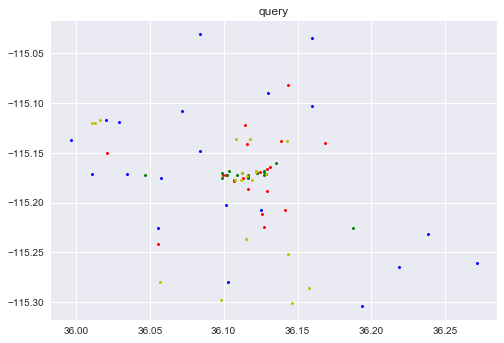

In [165]:
plt.plot(X1,Y1,'ro',markersize = 3)
plt.plot(X2,Y2,'bo',markersize = 3)
plt.plot(X3,Y3,'go',markersize = 3)
plt.plot(X4,Y4,'yo',markersize = 3)
plt.title('query')
plt.show()